# Remapping of bed machine Antarctica 1

Coordinates is given in meters in a polar stereographic coordinate reference system. We need to create the corresponding longitude/latitude arrays using the PROJ library.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import xesmf

In [2]:
#%matplotlib qt
%matplotlib inline

In [3]:
_ = xr.set_options(display_style='text')

## Adding lon/lat from the CRS

bedmachine coordinates are carthesian (in $m$, centered on the south pole) in a polar stereographic projection. To get the corresponding longitude/latitude, we use the inverse transformation from the CRS:

The PROJ string is available here: 
    
https://nsidc.org/data/NSIDC-0756/versions/1

In [4]:
PROJSTRING="+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

Write a function to compute the longitude and latitude using the inverse transformation from the CRS:

In [5]:
def add_lon_lat(ds, PROJSTRING, x='x', y='y', chunks={}):
    """ add longitude and latitude as compute from the inverse projection
    given in PROJSTRING
    
    PARAMETERS:
    -----------
    ds: xarray.Dataset
    
    PROJSTRING: str
    
    """
    from pyproj import CRS, Transformer
    # create the coordinate reference system
    crs = CRS.from_proj4(PROJSTRING)
    # create the projection from lon/lat to x/y
    proj = Transformer.from_crs(crs.geodetic_crs, crs)
    # make x,y 2d arrays
    xx, yy = np.meshgrid(ds[x].values, ds[y].values)
    # compute the lon/lat
    lon, lat = proj.transform(xx, yy, direction='INVERSE')
    # add to dataset
    ds['lon'] = xr.DataArray(data=lon, dims=('y', 'x'))
    ds['lat'] = xr.DataArray(data=lat, dims=('y', 'x'))
    ds['lon'].attrs = dict(units='degrees_east')
    ds['lat'].attrs = dict(units='degrees_north')
    return ds

Fist time computing lon/lat takes about 2 minutes. Write the results into a new file. Next time, we can just load the file:

In [6]:
compute_geo=False

In [7]:
%%time

if compute_geo:
    bedmachine = xr.open_dataset('BedMachineAntarctica_2019-11-05_v01.nc')
    # this should take a couple of minutes
    bedmachine = add_lon_lat(bedmachine, PROJSTRING)
    bedmachine = bedmachine.assign_coords({'lon': bedmachine.lon,
                                           'lat': bedmachine.lat})
    bedmachine.to_netcdf('bedmachine+geo.nc', format='NETCDF3_64BIT')
else:
    bedmachine = xr.open_dataset('bedmachine+geo.nc')

CPU times: user 25 ms, sys: 9.13 ms, total: 34.1 ms
Wall time: 57.8 ms


In [8]:
bedmachine

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
    lon        (y, x) float64 ...
    lat        (y, x) float64 ...
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 ...
    firn       (y, x) float32 ...
    surface    (y, x) float32 ...
    thickness  (y, x) float32 ...
    bed        (y, x) float32 ...
    errbed     (y, x) float32 ...
    source     (y, x) int8 ...
    geoid      (y, x) int16 ...
Attributes:
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     05-Nov-2019 (v1.38)
    nx:                          13333.0
    ny:                          13333.0
    Projection:                  Polar Stereographic South (71S,0E)
    proj4:                       +init=epsg:3031
    sea_water_density (kg m-3):  1027.0
    ice_density (kg m-3):        917.0
    xmin:                        -3333000
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

## Computing the elevation referenced to WGS84

[online doc](https://sites.uci.edu/morlighem/dataproducts/bedmachine-antarctica/) states: *All heights are referenced to mean sea level (using the geoid EIGEN-6C4). To convert the heights to heights referenced to the WGS84 ellipsoid, simply add the geoid height:*

$$ z_{ellipsoid}=z_{geoid}+geoid$$

which translates into:

In [9]:
bedmachine['elevation'] = bedmachine['bed'] + bedmachine['geoid']

## Comparison with GEBCOv2

In [10]:
gebco = xr.open_dataset('/work/Niki.Zadeh/datasets/topography/GEBCO_2014_2D.nc')

In [11]:
gebco

<xarray.Dataset>
Dimensions:    (lat: 21600, lon: 43200)
Coordinates:
  * lat        (lat) float64 -90.0 -89.99 -89.98 -89.97 ... 89.98 89.99 90.0
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    elevation  (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2014 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The bathymetric portion of the GEBCO_2014 Grid was largely ...
    history:      This is version 20150318 of the data set. Information on th...
    references:   Information on the data set is available from the GEBCO pro...
    comment:      The data in the GEBCO_2014 Grid should not be used for navi...
    node_offset:  1

For plotting, we don't need to use the full resolution of the datasets so we coarsen the datasets:

In [12]:
gebco_topo_subsample = gebco.elevation.coarsen(lon=50, lat=50).mean()

Text(0.5, 1.0, 'GEBCO2')

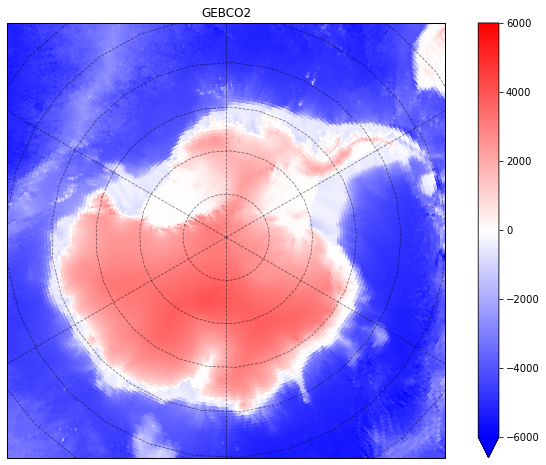

In [13]:
subplot_kws=dict(projection=ccrs.SouthPolarStereo(central_longitude=-120.),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = gebco_topo_subsample.plot(x='lon', y='lat',
                              vmin=-6000, vmax=6000,
                              cmap='bwr',
                              subplot_kws=subplot_kws,
                              transform=ccrs.PlateCarree(),
                              add_labels=False,
                              add_colorbar=True)

p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-300, 60, -60, -90], ccrs.PlateCarree())
p.axes.set_title('GEBCO2')

Text(0.5, 1.0, 'Bedmachine bedrock, ref to WGS84')

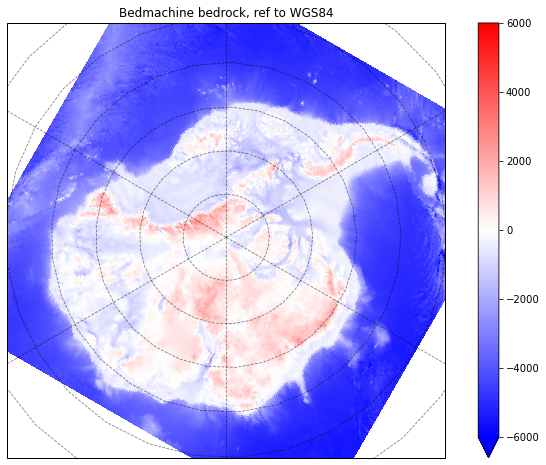

In [14]:
# round up for coarsening
start=0
end=13000

bedtmp = bedmachine.isel(x=slice(start,end),
                         y=slice(start,end))
                         

bedmachine_bed_subsample = bedtmp.elevation.coarsen(x=50, y=50).mean()


bedmachine_bed_subsample['lon'] = xr.DataArray(bedtmp['lon'].values[::50,::50],
                                               dims=('y', 'x'))
bedmachine_bed_subsample['lat'] = xr.DataArray(bedtmp['lat'].values[::50,::50],
                                               dims=('y', 'x'))

subplot_kws=dict(projection=ccrs.SouthPolarStereo(central_longitude=-120.),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = bedmachine_bed_subsample.plot(x='lon', y='lat',
                                  vmin=-6000, vmax=6000,
                                  cmap='bwr',
                                  subplot_kws=subplot_kws,
                                  transform=ccrs.PlateCarree(),
                                  add_labels=False,
                                  add_colorbar=True)

p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-300, 60, -60, -90], ccrs.PlateCarree())
p.axes.set_title('Bedmachine bedrock, ref to WGS84')

## Remapping onto GEBCOv2 grid:

Because of the bedmachine projection geometry, we can only remap bedmachine south of 62S.

To be computationally efficient, we subset the coordinates of the GEBCO grid south of 62S:

In [15]:
gebco_SO = gebco.sel(lat=slice(-90, -62))

In [16]:
gebco_SO['lon'].attrs = dict(units='degrees_east')
gebco_SO['lat'].attrs = dict(units='degrees_north')

The regridding is too big to be done in a reasonable time without a HPC system. On a HPC with ESMF installed (e.g. using conda + install ESMF/ESMPy packages), we can use the parallel weights generation tool and an example invocation is:

the weight generation has its own [github](https://github.com/raphaeldussin/regrid_weights_bedmachine_gebco)/[gitlab](https://gitlab.gfdl.noaa.gov/ogrp/regrid_weights_bedmachine_gebco) repos and results were stored on PPAN:

In [17]:
weightsdir = '/work/Raphael.Dussin/weights_save/bedmachine_gebco_gaea'

Once the weights are created, we can use them within xESMF:

In [18]:
%%time

regrid = xesmf.Regridder(bedmachine, gebco_SO,
                         method='nearest_s2d',
                         periodic=False,
                         reuse_weights=True,
                         filename=f'{weightsdir}/nearest_weights_srcR.nc')

Reuse existing file: /work/Raphael.Dussin/weights_save/bedmachine_gebco_gaea//nearest_weights_srcR.nc
CPU times: user 3.89 s, sys: 8.84 s, total: 12.7 s
Wall time: 30.7 s


And create the remapped elevation:

In [21]:
%%time

bedmachine_remapped = xr.Dataset()

bedmachine_remapped['elevation'] = regrid(bedmachine['elevation'])

# gebco is given in type short, which basically is equivalent to integer values,
# hence no need to save decimal points...
encoding = {'elevation': {'dtype': np.int16}}
bedmachine_remapped.to_netcdf('BedMachineAntarctica_elevation_nn_gebco_grid.nc',
                              encoding=encoding, format='NETCDF3_64BIT',
                              engine='netcdf4')

<timed exec>:8: SerializationWarning: saving variable elevation with floating point data as an integer dtype without any _FillValue to use for NaNs


CPU times: user 1.5 s, sys: 2.16 s, total: 3.66 s
Wall time: 5.4 s


In [22]:
%%time

remap_extras=False

if remap_extras:
    bedmachine_remapped_extras = xr.Dataset()
    for var in ['bed', 'firn', 'surface', 'thickness', 'geoid']:
        bedmachine_remapped_extras[var] = regrid(bedmachine[var])
    bedmachine_remapped_extras.to_netcdf('BedMachineAntarctica_regridded_nn_gebco.nc')

CPU times: user 4 µs, sys: 6 µs, total: 10 µs
Wall time: 16.5 µs


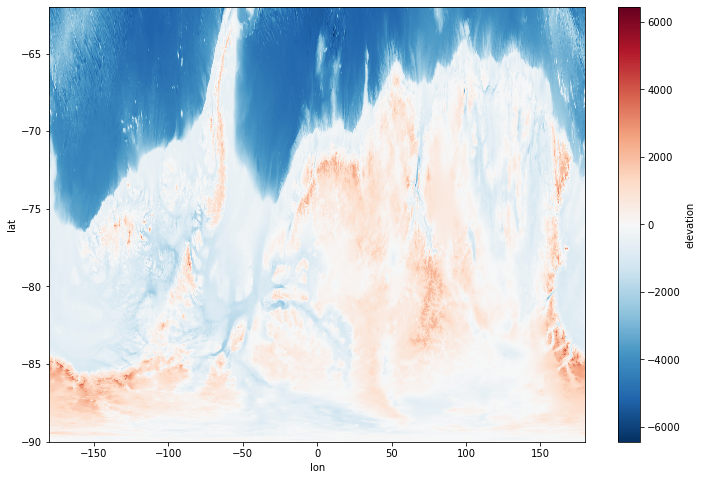

In [23]:
plt.figure(figsize=[12,8])
bedmachine_remapped['elevation'].plot()

The resulting remapping passes the eyeball test. To be certain we can plot the difference with gebco:

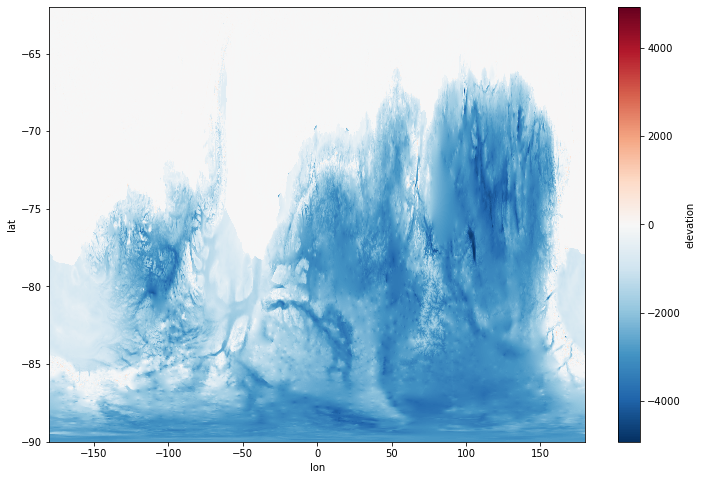

In [25]:
plt.figure(figsize=[12,8])
diffbathy = bedmachine_remapped['elevation'].astype(np.int16) - gebco_SO['elevation']
diffbathy.plot()

This shows clearly the difference between bedmachine bedrock and gebco "top of the ice" elevation. Focusing on the northern part of the domain, where the merging will happen, we don't notice any suspicious mismatch (just noise)

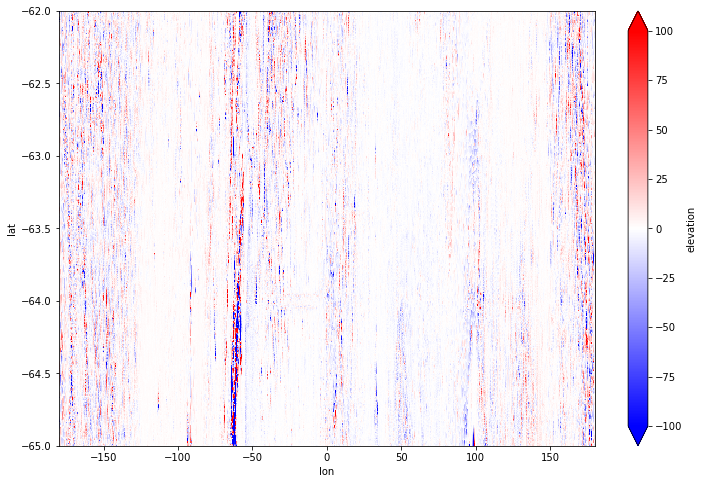

In [27]:
plt.figure(figsize=[12,8])
diffbathy.sel(lat=slice(-65,-62)).plot(vmin=-100, vmax=100, cmap='bwr')

Continue to merge bathy...